# Linear and convolutional autoencoders

An autoencoder is a neural network that can be used to encode and decode data. The general structure of an autoencoder is shown in the figure below. It consists of two parts: an encoder and a decoder. The encoder compresses the input data into a lower dimensional representation (often referred to as the _latent space representation_) by extracting the most salient features of the data, while the decoder reconstructs the input data from the compressed representation. Therefore, autoencoder is often used for _dimensionality reduction_. In this tutorial, our goal is to compare the performance of two types of autoencoders, a linear autoencoder and a convolutional autoencoder, on reconstructing the [`Fashion-MNIST`](https://github.com/zalandoresearch/fashion-mnist) images. With the help of Covalent, we will see how to break a complex workflow into smaller and more manageable tasks, which allows users to track the task dependencies and execution results of individual steps. Another advantage of Covalent is its ability to auto-parallelize the execution of subtasks.

<div align="center">
<img src="././autoencoder_images/schematic.png" style="width: 40%; height: 40%"/>
</div>


## Building the autoencoders

We will build the two types of autoencoders in [PyTorch](https://pytorch.org/). The linear autoencoder is built on the [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) layers, while the convolutional autoencoder is built on the [`Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) layers. Let us first install all the necessary dependencies for this tutorial.


In [1]:
# !pip install cova
# !pip install torch torchvision
# !pip install matplotlib

We can then start the Covalent UI and the local dispatcher server by running `!covalent start`. The UI will be available at http://localhost:8080. Next, we import the following modules:


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import covalent as ct

The linear and convolutional autoencoders are implemented as classes inheriting from the [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class in PyTorch. In the case of a linear autoencoder, we will use four hidden layers in the encoder. Between each layer the `ReLU` activation function is applied. The decoder is essentially the "inverse" of the encoder, and we will use the same architecture for it except at the end an additional `Sigmoid` activation function is applied. The choice of this activation function depends on the range of the pixel intensity in the original input data. Note that the `Fashion-MNIST` dataset contains 28x28-pixel gray-scale images, so the input dimension of each image is 28x28x1. The compressed images generated by the encoder would have dimension 3x3x1 in this case.


In [2]:
class LinearAutoencoder(nn.Module):
    """Autoencoder with 4 hidden layers."""

    def __init__(self):
        super(LinearAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),  # input size = 784 -> hidden size = 128
            nn.ReLU(True),
            nn.Linear(128, 64),  # hidden size = 128 -> hidden size = 64
            nn.ReLU(True),
            nn.Linear(64, 12),  # hidden size = 64 -> hidden size = 12
            nn.ReLU(True),
            nn.Linear(12, 3),  # hidden size = 12 -> output size = 3
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),  # input size = 3 -> hidden size = 12
            nn.ReLU(True),
            nn.Linear(12, 64),  # hidden size = 12 -> hidden size = 64
            nn.ReLU(True),
            nn.Linear(64, 128),  # hidden size = 64 -> hidden size = 128
            nn.ReLU(True),
            nn.Linear(128, 28*28),  # hidden size = 128 -> output size = 784
            nn.Sigmoid()  # output with pixel intensity in [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

For the convolutional autoencoder, we will use three hidden layers. Each convolutional layer except for the last one in the encoder will use the `Conv2d` construction with a kernel size of 3x3, a stride of 1, and a padding of 1, followed by a `ReLU` activation function. The decoder will use the `ConvTranspose2d` layers to reverse the action of the `Conv2d` layers in the encoder, followed by a `Sigmoid` activation function.


In [3]:
class ConvAutoencoder(nn.Module):
    """Autoencoder with 3 hidden layers."""

    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # input size = 1x28x28 -> hidden size = 16x14x14
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # hidden size = 16x14x14 -> hidden size = 32x7x7
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7),  # hidden size = 32x7x7 -> hidden size = 64x1x1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # input size = 64x1x1 -> hidden size = 32x7x7
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # hidden size = 32x7x7 -> hidden size = 16x14x14
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # hidden size = 16x14x14 -> hidden size = 1x28x28
            nn.Sigmoid()  # output with pixels in [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Creating the workflow


Let us now build a workflow that can encompass both autoencoders. Overall, the workflow consists of five tasks. We begin by creating a `data_loader` that loads the data from the `Fashion-MNIST` dataset, along with custom preprocessing if necessary. We will add the `electron` decorator on this function, making it a subtask in the Covalent workflow.


In [4]:
@ct.electron
def data_loader(
    batch_size: int,
    train: bool,
    download: bool = True,
    shuffle: bool = True,
    transform: transforms.Compose = None,
) -> torch.utils.data.DataLoader:
    """
    Loads the Fashion MNIST dataset.

    Args:
        batch_size: The batch size.
        train: Whether to load the training or test set.
        download: Whether to download the dataset.
        shuffle: Whether to shuffle the dataset.
        transform: A transform to apply to the dataset.

    Returns:
        A DataLoader for the Fashion MNIST dataset.
    """
    if transform is None:
        transform = transforms.Compose([transforms.ToTensor()])

    dataset = datasets.FashionMNIST(
        "./data", train=train, download=download, transform=transform
    )

    return torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

Then we need to choose an optimizer for training the autoencoders. We will use the [`Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer for this tutorial.


In [13]:
@ct.electron
def get_optimizer(model: nn.Module, lr: float) -> optim.Optimizer:
    """
    Returns an Adam optimizer for the given model.

    Args:
        model: A PyTorch model.
        lr: The learning rate.

    Returns:
        An Adam optimizer for the given model.
    """
    return optim.Adam(model.parameters(), lr=lr)

Now we define the training process over multiple epochs. To optimize the autoencoders, we choose the mean squared error (`MSE`) between the original and reconstructed images as the reconstruction loss. During training, we will keep track of the reconstruction loss after each epoch. We will also log the output images after a certain number of epochs specified by the `log_interval`.

In [14]:
@ct.electron
def train_model(
    model: nn.Module,
    optimizer: optim.Optimizer,
    data_loader: torch.utils.data.DataLoader,
    epochs: int,
    log_interval: int,
):
    """
    Trains the given model on the Fashion MNIST dataset.

    Args:
        model: A PyTorch model.
        optimizer: An Adam optimizer for the model.
        data_loader: A DataLoader for the Fashion MNIST dataset.
        epochs: The number of epochs to train for.
        log_interval: The number of epochs to wait before logging in the outputs.

    Returns:
        train_loss: A list of training losses for each epoch.
        outputs: Contains epoch number, the original image, and the reconstructed image at each training step.
        model: The trained model.
    """
    model.train()
    outputs = []
    train_loss = []
    for epoch in range(1, epochs + 1):
        running_loss = 0
        for (data, _) in data_loader:
            if isinstance(model, LinearAutoencoder):
                data = data.view(data.size(0), -1)
            recon = model(data)
            loss = nn.MSELoss()(recon, data)  # mean squared error loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss / len(data_loader)
        train_loss.append(loss)
        if epoch % log_interval == 0:
            outputs.append((epoch, data, recon))
            print(f"Epoch {epoch}, loss: {loss}")
    return train_loss, outputs, model

After the training is complete, we will test the performance of our autoencoders on the test set and compare the average test loss with the training losses.

In [15]:
@ct.electron
def test_model(model: nn.Module, data_loader: torch.utils.data.DataLoader):
    """
    Tests the given model on the Fashion MNIST dataset.

    Args:
        model: A PyTorch model.
        data_loader: A DataLoader for the Fashion MNIST dataset.

    Returns:
        avg_test_loss: The average loss for the test set.
    """
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for (data, _) in data_loader:
            if isinstance(model, LinearAutoencoder):
                data = data.view(data.shape[0], -1)
            recon = model(data)
            loss = nn.MSELoss()(recon, data)  # mean squared error loss
            test_loss += loss.item()
    avg_test_loss = test_loss / len(data_loader)
    print(f"Average test loss: {avg_test_loss}")
    return avg_test_loss

With the above subtasks properly set up, it is time to bundle them into one single workflow that can be dispatched using Covalent.

In [16]:
@ct.lattice
def workflow(
    model: nn.Module,
    epochs: int,
    log_interval: int,
    batch_size_train: int = 64,
    batch_size_test: int = 1000,
    lr: float = 1e-3
):
    """
    Full workflow of training and testing the autoencoder on the Fashion MNIST dataset.

    Args:
        model: A PyTorch model.
        epochs: The number of epochs to train for.
        log_interval: The number of epochs to wait before logging in the outputs.
        batch_size_train: The batch size for the training set.
        batch_size_test: The batch size for the test set.
        lr: The learning rate.

    Returns:
        train_loss: The training loss at each epoch.
        avg_test_loss: The average loss for the test set.
        outputs: Contains epoch number, the original image, and the reconstructed image at each training step.
    """
    train_loader = data_loader(batch_size=batch_size_train, train=True)
    test_loader = data_loader(batch_size=batch_size_test, train=False)

    optimizer = get_optimizer(model=model, lr=lr)
    train_loss, outputs, model = train_model(
        model=model, optimizer=optimizer, data_loader=train_loader, epochs=epochs, log_interval=log_interval
    )
    avg_test_loss = test_model(model=model, data_loader=test_loader)
    
    return train_loss, avg_test_loss, outputs

## Linear vs. convolutional autoencoders

We will now run the workflow for both the linear and convolutional autoencoders and compare their performances.

In [21]:
workflow(model=LinearAutoencoder().to("cpu"), epochs=5, log_interval=1);

Epoch 1, loss: 0.04199379066755967
Epoch 2, loss: 0.028038432857375156
Epoch 3, loss: 0.02603364427055695
Epoch 4, loss: 0.025141371983979175
Epoch 5, loss: 0.02446325825078528
Average test loss: 0.0244443342089653


In [17]:
lin_dispatch_id = ct.dispatch(workflow)(model=LinearAutoencoder().to("cpu"), epochs=5, log_interval=1)
lin_result = ct.get_result(dispatch_id=lin_dispatch_id, wait=True)

In [18]:
lin_train_loss, lin_avg_test_loss, lin_outputs = lin_result.result

In [19]:
lin_train_loss

[0.1706758508963117,
 0.17066970383371116,
 0.17067653523769968,
 0.17067535294652747,
 0.17067256660413133]

Let us also inspect the training loss as a function of the number of epochs.

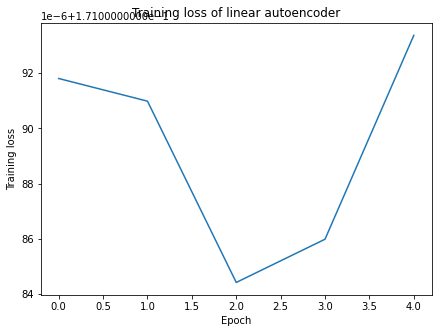

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="w")
ax.plot(lin_train_loss)
ax.set_title("Training loss of linear autoencoder")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training loss")
plt.show()

We also want to display a few images at different phases of training to help us visualize how the reconstructed images compare with the original ones.

In [13]:
def plot_outputs(outputs: tuple):
    """
    Plots the outputs of the workflow.

    Args:
        outputs: The outputs of the workflow.
    """
    for i in range(len(outputs)):
        plt.figure(figsize=(12, 4), facecolor="w")
        plt.gray()
        plt.suptitle(f'Epoch {outputs[i][0]}')
        imgs = outputs[i][1].detach().numpy()  # original images
        recon = outputs[i][2].detach().numpy()  # reconstructed images
        for j, item in enumerate(imgs):
            while j < 5:
                plt.subplot(2, 5, j + 1)
                item = item.reshape(-1, 28, 28)
                plt.imshow(item[0])
                plt.axis("off")
                j += 1
        
        for j, item in enumerate(recon):
            while j < 5:
                plt.subplot(2, 5, j + 6)
                item = item.reshape(-1, 28, 28)
                plt.imshow(item[0])
                plt.axis("off")
                j += 1

plot_outputs(lin_outputs)

In [ ]:
conv_dispatch_id = ct.dispatch(workflow)(model=ConvAutoencoder(), epochs=40, log_interval=10)
conv_result = ct.get_result(dispatch_id=conv_dispatch_id, wait=True)

In [ ]:
conv_train_loss, conv_avg_test_loss, conv_outputs = conv_result.result

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="w")
ax.plot(conv_train_loss)
ax.set_title("Training loss of convolutional autoencoder")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training loss")
plt.show()

In [ ]:
plot_outputs(conv_outputs)